In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import sklearn.preprocessing
from torchmetrics.regression import MeanAbsolutePercentageError

This data is CGM values in mg/dl and is in 15 minute increments. Each row is a new patient (97 patients) and each column is a reading. Each patient has 480 readings or 5 days of data 

In [26]:
df = pd.read_csv("cgm_data.csv")
for column in df.columns:
    df[column] = df[column].astype(float) #convert columns into floats
ptids = df["ptid"]
df = df.drop("ptid",axis=1)
df = df.iloc[:96,:] # keep only 96 patients

In [27]:
def train_test_split(df,training_patients, prediction_horizon, device):
    train_input = torch.from_numpy(df.iloc[:training_patients,:-prediction_horizon].values).float().to(device)
    train_target = torch.from_numpy(df.iloc[:training_patients,prediction_horizon:].values).float().to(device)
    test_input = torch.from_numpy(df.iloc[training_patients:,:-prediction_horizon].values).float().to(device)
    test_target = torch.from_numpy(df.iloc[training_patients:,prediction_horizon:].values).float().to(device)

    train_input = torch.unsqueeze(train_input,-1)
    train_target = torch.unsqueeze(train_target,-1)
    test_input = torch.unsqueeze(test_input,-1)
    test_target = torch.unsqueeze(test_target,-1)
    return train_input, train_target, test_input, test_target

In [33]:
class LSTMPredictor(torch.nn.Module):
    def __init__(self, num_layers = 2,n_hidden=51, dropout=0, device='cpu', batch_first=True):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.num_layers = num_layers
        self.device = device
        self.droupout = dropout
        # lstm1, linear
        
        self.lstm = torch.nn.LSTM(input_size = 1,
                                  hidden_size = self.n_hidden, 
                                  num_layers=self.num_layers, 
                                  dropout = self.droupout, 
                                  device=self.device,
                                  batch_first=True)
        
        self.linear = torch.nn.Linear(self.n_hidden,
                                      1, 
                                      device=self.device)
        
    def forward(self,x):
        x = x.to(self.device)
        h_t = torch.zeros(self.num_layers, x.shape[0],self.n_hidden, dtype = torch.float32, device=self.device)
        c_t = torch.zeros(self.num_layers, x.shape[0],self.n_hidden, dtype = torch.float32, device=self.device)

        output, hidden = self.lstm(x, (h_t,c_t))
        h_t,c_t = hidden
        output = self.linear(output)
        return output

### Graph 1 Loss Curve prediction horizon 1

torch.Size([6, 479, 1])

In [69]:
a = torch.cat(pred, axis=1)
a.unsqueeze(2)
a.shape

TypeError: cat() received an invalid combination of arguments - got (Tensor, axis=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [99]:
#data parameters
device = 'cuda'
training_patients = 90
prediction_horizon = 1

#hyperparameters
n_hidden= 50
num_layers = 2
learning_rate = 0.005

#training parameters
epochs = 3000

#train test split
train_input, train_target, test_input, test_target = train_test_split(df,training_patients, prediction_horizon, device)
#create model
model = LSTMPredictor(n_hidden=n_hidden,num_layers=num_layers,device=device)
criterion = MeanAbsolutePercentageError().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train and predict

losses = []
test_losses = []
for i in tqdm(range(epochs)):
    model.zero_grad()
    out = model(train_input)
    loss = criterion(out,train_target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        future= 0
        pred = model(test_input)
        loss = criterion(pred, test_target)
        test_losses.append(loss.item())

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:23<00:00, 126.18it/s]


In [93]:
torch.save(model, "LSTM")

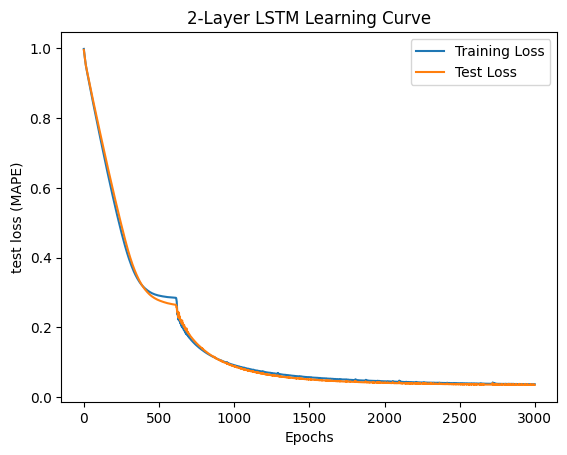

0.034972693771123886


In [100]:
#Training Curve
plt.figure()
plt.plot(range(epochs), losses, label = "Training Loss")
plt.plot(range(epochs), test_losses, label = "Test Loss")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Epochs")
plt.title("2-Layer LSTM Learning Curve")
plt.legend()
plt.show()
print(test_losses[-1])

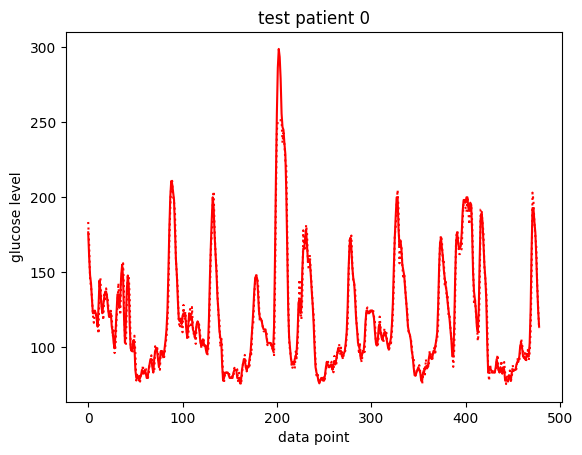

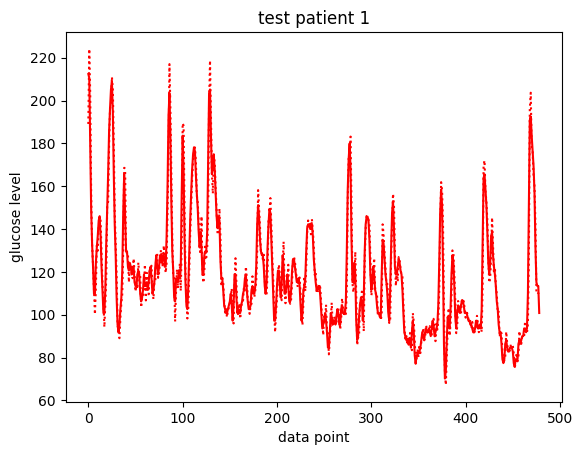

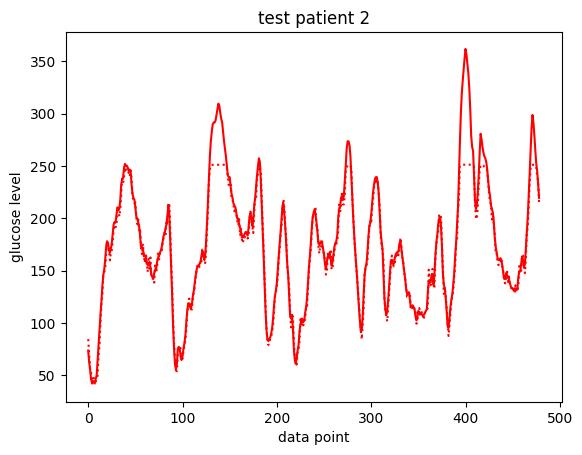

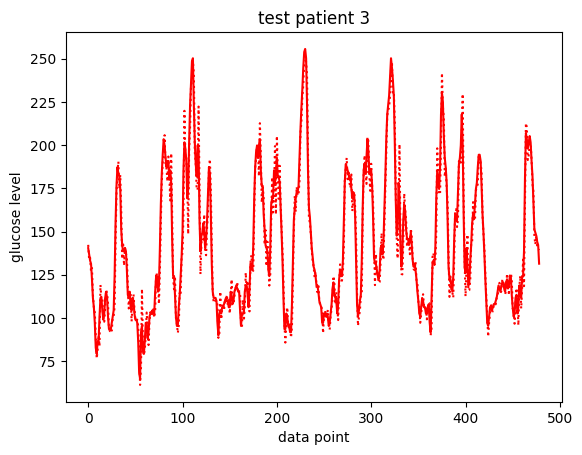

In [102]:
def draw(true, pred, index,future, color):
    true = true.to('cpu')
    pred = pred.to("cpu")
    plt.figure()
    plt.title(f"test patient {index}")
    plt.xlabel("data point")
    plt.ylabel("glucose level")
    plt.xticks()
    plt.yticks()
    n = train_input.shape[1]
    plt.plot(np.arange(n), true[index,:], color)
    plt.plot(np.arange(n+future), pred[index,:], color + ":")
    plt.show()

    
draw(test_target, pred,0,0,'r')
draw(test_target, pred,1,0,'r')
draw(test_target, pred,2,0,'r')
draw(test_target, pred,3,0,'r')



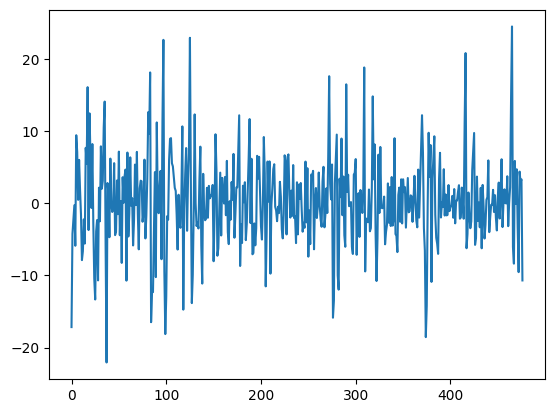

In [44]:
plt.figure()
plt.plot(range(len(test_target[1,2:])),test_target[1,2:].to('cpu') - pred[1,2:].to('cpu'))
plt.show()

## Graph 2 Variable Time Horizon

In [104]:
#data parameters
device = 'cuda'
training_patients = 90
prediction_horizons = range(1,9)

#hyperparameters
n_hidden= 50
num_layers = 2
learning_rate = 0.005

#training parameters
epochs = 3000

final_test_losses = []

for prediction_horizon in prediction_horizons:
    #train test split
    train_input, train_target, test_input, test_target = train_test_split(df,training_patients, prediction_horizon, device)
    #create model
    model = LSTMPredictor(n_hidden=n_hidden,num_layers=num_layers,device=device)
    criterion = MeanAbsolutePercentageError().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #train and predict

    losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        model.zero_grad()
        out = model(train_input)
        loss = criterion(out,train_target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            future= 0
            pred = model(test_input)
            loss = criterion(pred, test_target)
            test_losses.append(loss.item())
    final_test_losses.append(test_losses[-1])

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:23<00:00, 130.02it/s]


In [128]:
[15*x for x in prediction_horizons]

[15, 30, 45, 60, 75, 90, 105, 120]

In [105]:
final_test_losses

[0.03495712950825691,
 0.073238305747509,
 0.09919385612010956,
 0.1207990050315857,
 0.1393151581287384,
 0.15807285904884338,
 0.17017719149589539,
 0.1810360997915268]

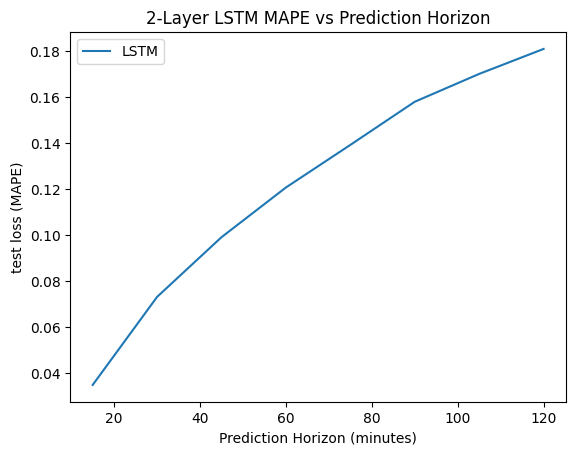

In [113]:
#Training Curve
plt.figure()
plt.plot([15*x for x in prediction_horizons],final_test_losses, label = "LSTM")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Prediction Horizon (minutes)")
plt.title("2-Layer LSTM MAPE vs Prediction Horizon")
plt.legend()
plt.show()

## Graph 3 Variable Training Patients 

In [130]:
#data parameters
device = 'cuda'
training_patients_sizes = [1,10,20,30,40,50,60,70,80,90]
prediction_horizon = 3

#hyperparameters
n_hidden= 50
num_layers = 2
learning_rate = 0.005

#training parameters
epochs = 5000

final_test_losses = []

for training_patients in training_patients_sizes:
    #train test split
    train_input, train_target, test_input, test_target = train_test_split(df,training_patients, prediction_horizon, device)
    #create model
    model = LSTMPredictor(n_hidden=n_hidden,num_layers=num_layers,device=device)
    criterion = MeanAbsolutePercentageError().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #train and predict

    losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        model.zero_grad()
        out = model(train_input)
        loss = criterion(out,train_target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            future= 0
            pred = model(test_input)
            loss = criterion(pred, test_target)
            test_losses.append(loss.item())
    final_test_losses.append(test_losses[-1])

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 129.30it/s]


In [131]:
training_patients_sizes

[1, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [132]:
final_test_losses

[0.41088104248046875,
 0.15888269245624542,
 0.13737273216247559,
 0.11294775456190109,
 0.10718260705471039,
 0.10368259996175766,
 0.11657378077507019,
 0.11990369856357574,
 0.11439451575279236,
 0.1001301258802414]

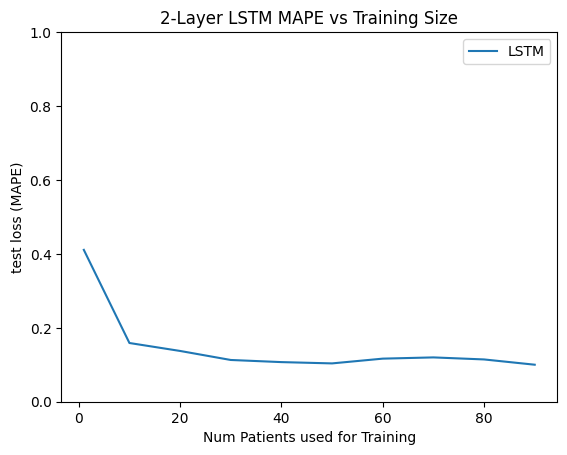

In [133]:
#Training Curve
plt.figure()
plt.plot(training_patients_sizes,final_test_losses, label = "LSTM")
plt.ylabel("test loss (MAPE)")
plt.xlabel("Num Patients used for Training")
plt.title("2-Layer LSTM MAPE vs Training Size")
plt.ylim(0,1)
plt.legend()
plt.show()